In [2]:
id = 1
pID = 'sub-' + "%01d" % (id)

In [3]:
import os

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC

from sklearn.model_selection import cross_val_score, KFold

import pickle, json, os
import scipy.io
# from bci_funcs import windowed_mean, base_correct, select_mean, slope

# path = '/Volumes/Lukas_Gehrke/fastReach/data/eeglab2python'
# path = 'P:\\Lukas_Gehrke\\fastReach\\data\\eeglab2python'
path = '/Users/lukasgehrke/Documents/publications/2022-CHI-neuroadaptive-haptics/data/5_single-subject-EEG-analysis'

# Neuroadaptive Haptic BCI Training

In [5]:
# load data
erp = scipy.io.loadmat(path+os.sep+pID+os.sep+'erp.mat')['erp']
# pandas load design matrix called behavior
behavior = pd.read_csv(path+os.sep+pID+os.sep+'behavior_s'+str(id)+'.csv', sep=';')

# Compute Features & Model fitting

LDA accuracy: 0.4 +/- 0.11040538534159479


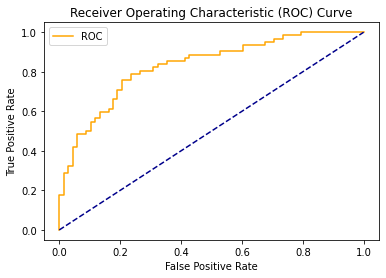

Threshold value is: 0.4538737331115277
F1 Score: 0.7540983606557377
Threshold used is: 0.5111517354836219
{'windows': 10, 'baseline': 25.0, 'target_class': 1, 'f1': 0.7540983606557377, 'threshold': 0.5111517354836219, 'acc': 0.4, 'acc_std': 0.11040538534159479, 'data_srate': 250}


In [15]:
# TODO fix parameters for BCI
data_srate = 250
windows = 10
baseline = data_srate/windows
target_class = 1

# randomly fill column answerID with values ranging 1-5
behavior['answerID'] = np.random.randint(1, 6, behavior.shape[0])

# select indeces in behavior where answerID is > median
low = behavior[behavior['answerID'] > behavior['answerID'].median()].index
high = behavior[behavior['answerID'] < behavior['answerID'].median()].index

# erp low
erp_low = erp[:,50,low]
# erp high
erp_high = erp[:,50,high]

# flatten this into 2d array of shape (trials, channels*data)
# erp_low = erp_low.reshape(erp_low.shape[2], erp_low.shape[0]*erp_low.shape[1])
# erp_high = erp_high.reshape(erp_high.shape[2], erp_high.shape[0]*erp_high.shape[1])
data = np.concatenate((erp_low, erp_high), axis = 1).T

low_class = np.zeros((erp_low.shape[1], 1))
high_class = np.ones((erp_high.shape[1], 1))
classes = np.concatenate((low_class, high_class)).ravel()

clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)
kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
acc = cv_results.mean()
acc_std = cv_results.std()
print("LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))
### END ###

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def interp_roc_curve(true, score, by ='fp', byval = np.linspace(0,1,101)):
    fp, tp, th =  roc_curve(true, score)
    data = {'fp': fp, 'tp': tp, 'th': th}
    interpData = {}
    for k,v in data.items():
        if k==by:
            interpData[k] = byval
        else:
            interpData[k] = np.interp(byval, data[by], data[k])
    roc = pd.DataFrame.from_dict(interpData)
    return(roc)

predictions_prob = clf.predict_proba(data)
pred_classes = clf.predict(data)

roc = interp_roc_curve(classes, predictions_prob[:,1])

false_positive_rate, recall, thresholds = roc_curve(classes, predictions_prob[:,1])

np.savetxt(path+os.sep+pID+os.sep+'fpr.csv', roc.fp, delimiter=',')
np.savetxt(path+os.sep+pID+os.sep+'recall.csv', roc.tp, delimiter=',')

# np.savetxt(path+os.sep+pID+os.sep+'fpr.csv', false_positive_rate, delimiter=',')
# np.savetxt(path+os.sep+pID+os.sep+'recall.csv', recall, delimiter=',')

roc_auc = auc(false_positive_rate, recall)
plot_roc_curve(false_positive_rate, recall)

optimal_idx = np.argmax(recall - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

from sklearn.metrics import f1_score
f1 = f1_score(classes, pred_classes)
print("F1 Score: "+ str(f1_score(classes, pred_classes)))

# save model
filename = path+os.sep+pID+os.sep+'model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))

# threshold = cv_results.mean()
threshold = np.min(thresholds[false_positive_rate<.2])
print("Threshold used is:", threshold)

bci_params = dict(((k, eval(k)) for k in ('windows', 'baseline', 'target_class', 'f1', 'threshold', 'acc', 'acc_std', 'data_srate')))
with open(path+os.sep+pID+os.sep+'bci_params.json', 'w') as f:
    json.dump(bci_params, f)
print(bci_params)